In [162]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set(style='darkgrid')
df = pd.read_excel('data_sample.xlsx')
df['cp_last_4_digit'] = df.caller_phone%10000
df['caller_phone_str'] = df['caller_phone'].apply(str)
# Удаляем номера длиной больше 11 символов
df = df[df['caller_phone_str'].str.len() == 11]
# df.info()

phone_capacity = pd.read_excel('phone_capacity.xlsx')

### Добавляем данные по региону, оператору, типу номера(ABC, DEF)

In [163]:
def set_pc_type(phone):
    code = phone['caller_phone_str'][1:4]
    body = phone['caller_phone_str'][4:11]
    phone_type_df = phone_capacity[(phone_capacity['code'] == int(code)) & (phone_capacity['body_min'] <= int(body)) & (phone_capacity['body_max'] >= int(body))]
    if phone_type_df.shape[0] == 0:
        return 'not set'
    return phone_type_df['type'].iloc[0]

def set_region(phone):
    code = phone['caller_phone_str'][1:4]
    body = phone['caller_phone_str'][4:11]
    phone_type_df = phone_capacity[(phone_capacity['code'] == int(code)) & (phone_capacity['body_min'] <= int(body)) & (phone_capacity['body_max'] >= int(body))]
    if phone_type_df.shape[0] == 0:
        return 'not set'
    return phone_type_df['region'].iloc[0]

def set_operator_name(phone):
    code = phone['caller_phone_str'][1:4]
    body = phone['caller_phone_str'][4:11]
    phone_type_df = phone_capacity[(phone_capacity['code'] == int(code)) & (phone_capacity['body_min'] <= int(body)) & (phone_capacity['body_max'] >= int(body))]
    if phone_type_df.shape[0] == 0:
        return 'not set'
    return phone_type_df['operator_name_short'].iloc[0]

def set_region_grouped(region):
    if region['phone_region'] in ['г. Москва и Московская область', 'г. Москва']:
        return 'Москва и МО'
    elif region['phone_region'] in ['г. Санкт-Петербург и Ленинградская область']:
        return 'Санкт-Петербург и ЛО'
    elif region['phone_region'] in ['not set', 'Краснодарский край', 'Республика Дагестан']:
        return region['phone_region']
    else:
        return 'Other regions'

df[['phone_type', 'phone_region', 'operator_name']] = df.apply(lambda row: pd.Series([set_pc_type(row), set_region(row), set_operator_name(row)]), axis = 1)
df['operator_name_grouped'] = df.apply(lambda x: x['operator_name'] if x['operator_name'] in ['Мегафон', 'Билайн', 'МТС', 'Tele2', 'not set'] else 'Other operators', axis = 1)

df['phone_region_grouped'] = df.apply(lambda x: set_region_grouped(x), axis = 1)

### Общая информация

In [256]:
cols = ['affiliate_name', 'key', 'value']
df_1 = df.groupby('affiliate_name').count().dt.reset_index()
df_1.rename(columns={'dt':'value'}, inplace = True)
df_1['key'] = '1. Кол-во звонков'
df_1 = df_1.reindex(columns=cols)

df_2 = df.groupby(by=['affiliate_name','attr1']).count().dt.reset_index()
df_2.rename(columns={'dt':'value'}, inplace = True)

df_2['total'] = df_2.groupby(by=['affiliate_name']).transform('sum')['value']
df_2['perc'] = df_2['value'] / df_2['total']
df_2[['perc']] = df_2[['perc']].applymap('{:.1%}'.format)
df_2['value'] = df_2['value'].map(str) + ' / ' + df_2['perc'].map(str)

df_2['attr1'] = '2. Категория: ' + df_2['attr1'] + ' (всего / доля)'
df_2.rename(columns={'attr1':'key'}, inplace = True)
df_2.drop(['total', 'perc'], axis = 1, inplace = True)
df_2 = df_2.reindex(columns=cols)

df_3 = df.groupby('affiliate_name').mean().duration.reset_index()
df_3.rename(columns={'duration':'value'}, inplace = True)
df_3[['value']] = df_3[['value']].applymap('{:.0f}'.format)
df_3['key'] = '3. Средняя длительность, сек'
df_3 = df_3.reindex(columns=cols)

df_4 = df.groupby('affiliate_name').sum().cost.reset_index()
df_4.rename(columns={'cost':'value'}, inplace = True)
df_4[['value']] = df_4[['value']].applymap('{:.0f}'.format)
df_4['key'] = '{}'.format('4. Стоимость')
df_4 = df_4.reindex(columns=cols)

df_5 = df[df['attr1'] == 'Целевой'].groupby('affiliate_name').aggregate({'cost': 'sum', 'dt': 'count'}).reset_index()
df_5['value'] = df_5['cost'] / df_5['dt']
df_5[['value']] = df_5[['value']].applymap('{:.0f}'.format)
df_5['key'] = '5. Цена Целевого звонка'
df_5.drop(['cost', 'dt'], axis = 1, inplace = True)
df_5 = df_5.reindex(columns=cols)



df_table = pd.concat([df_1, df_2, df_3, df_4, df_5]).reset_index(drop=True)
result = pd.pivot_table(df_table, values=['value'], index=['key'], columns=['affiliate_name'], aggfunc=lambda x: ' '.join(str(v) for v in x)).reset_index()

result.style.set_properties(**{'background-color': 'black',
                           'color': 'lawngreen',
                           'border-color': 'white'}).set_properties(subset=['key'], **{'text-align': 'left'})

### Количество звонков по affiliates

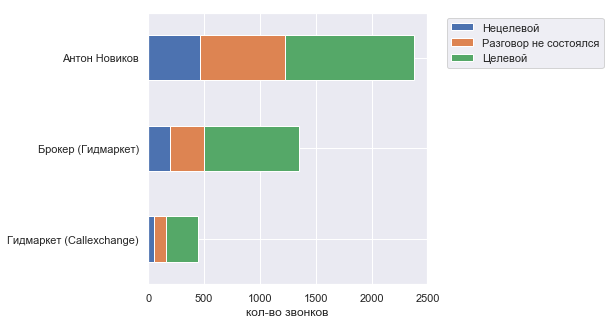

In [4]:
df_by_affiliates = df.groupby(by=['affiliate_name', 'attr1']).count().unstack().dt
df_by_affiliates['Total'] = df_by_affiliates.sum(axis=1)
# df_by_affiliates.sort_values(by='Total', ascending = True).drop('Total', axis =1 )
plot = df_by_affiliates.sort_values(by='Total', ascending = True).drop('Total', axis =1).plot.barh(stacked=True, figsize = (5,5))
plot.set_xlabel("кол-во звонков")
plot.set_ylabel("")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)


### Дальше работаем только с Целевыми звонками

In [5]:
df = df[df['attr1'] == 'Целевой'].reset_index(drop=True)

### Смотрим распределение последних четырёх цифр клиентских номеров

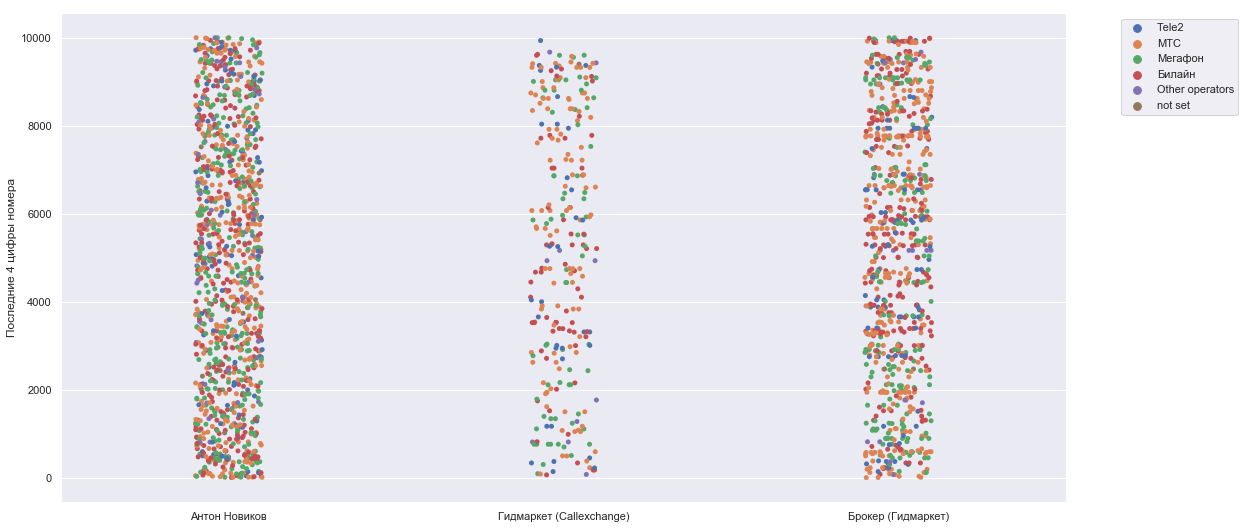

In [6]:
df['last_4_digits'] = df['caller_phone']%10000

fig, ax = plt.subplots(figsize=(18, 9))
sns.stripplot(x='affiliate_name', y = 'last_4_digits', hue = 'operator_name_grouped',  data = df)
ax.set(xlabel='', ylabel='Последние 4 цифры номера')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

### Сравнение партнёров по регионам

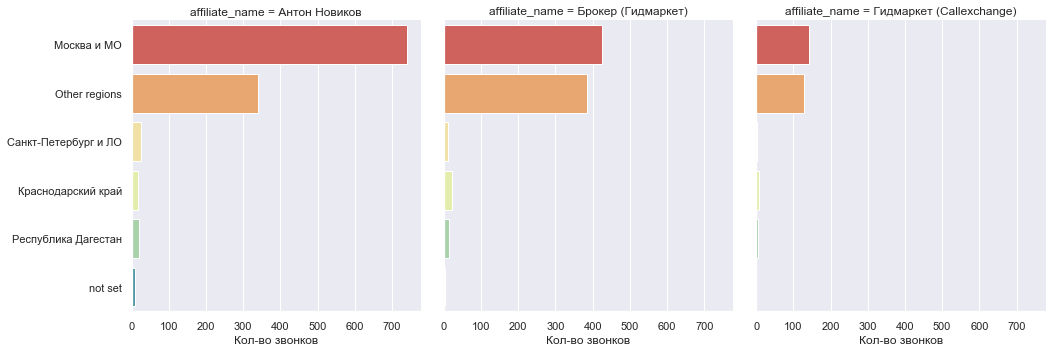

In [7]:
regions_stat =  df.groupby(by=[df['affiliate_name'], df['phone_region_grouped']]).agg({'caller_phone': 'count'}).sort_values(by='caller_phone', ascending = False)
regions_stat.reset_index(inplace=True)

ax = sns.catplot(x = 'caller_phone', 
                 y = 'phone_region_grouped', 
                 col = 'affiliate_name', 
                 data = regions_stat, 
                 kind='bar', palette = 'Spectral', ci = None )
ax.set(xlabel = 'Кол-во звонков', ylabel = '')

### Сравнение партнёров по операторам

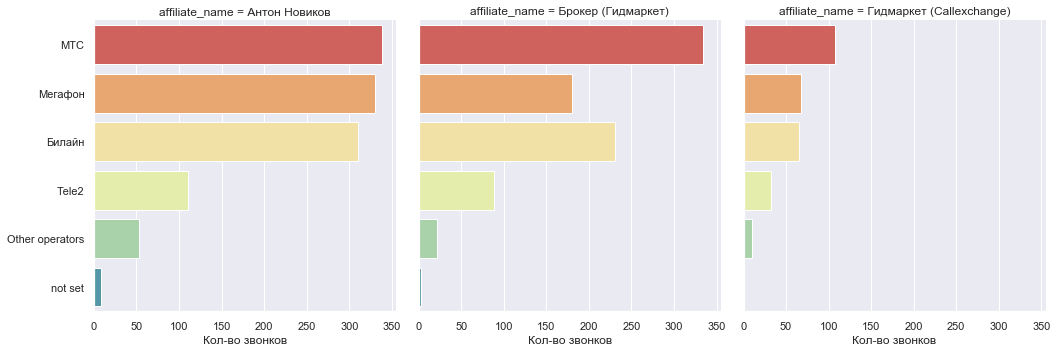

In [8]:
operators_stat =  df.groupby(by=[df['affiliate_name'], df['operator_name_grouped']]).agg({'caller_phone': 'count'}).sort_values(by='caller_phone', ascending = False)
operators_stat.reset_index(inplace=True)

ax = sns.catplot(x = 'caller_phone', 
                 y = 'operator_name_grouped', 
                 col = 'affiliate_name', 
                 data = operators_stat, 
                 kind='bar', palette = 'Spectral', ci = None )
ax.set(xlabel = 'Кол-во звонков', ylabel = '')

### Сравнение длительности Целевых звонков

[Text(0, 0.5, 'Длительность, сек'), Text(0.5, 0, '')]

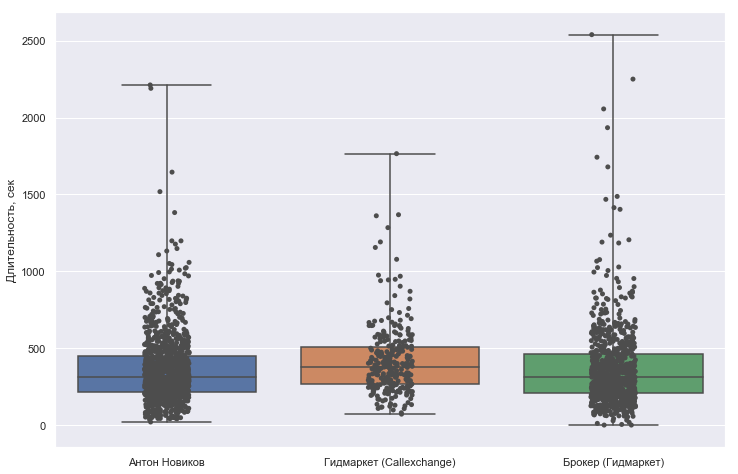

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='affiliate_name', y = 'duration', data = df, whis=np.inf)
sns.stripplot(x='affiliate_name', y = 'duration', data = df, color='.3')
ax.set(xlabel='', ylabel='Длительность, сек')

Распределение по кодам
Распределение по регионам
Распределение по операторам
Кол-во целевых звонков по дням мес

In [10]:
# operators_total['operator_name_grouped'] = operators_total['operator_name_grouped'].map('{:<20}'.format)

In [11]:
# NUM_BINS = 10

# df_cp_uniq = pd.DataFrame(df['caller_phone'].unique(), columns=['caller_phone'])
# df_cp_uniq['cp_last_4_digits'] = df_cp_uniq['caller_phone']%10000
# df_cp_uniq['cp_last_4_digits_bin'] = round(df_cp_uniq['cp_last_4_digits'] * NUM_BINS / 10000)
# hist, bin_edges = np.histogram(df_cp_uniq['cp_last_4_digits'], NUM_BINS)

# sns.distplot(df_cp_uniq['cp_last_4_digits'], kde=False, color='red', bins=NUM_BINS)
# # plt.hist(df_cp_uniq['cp_last_4_digits'], NUM_BINS)
# plt.axhline(hist.mean(), color='yellow', ls=':')
# plt.axhline(hist.mean() -  3 * hist.std(), color='red', ls='--')
# plt.axhline(hist.mean() +  3 * hist.std(), color='red', ls='--')

# plt.show()


In [12]:
# plt.subplot(2, 2, 1)
# ss.probplot(df['caller_phone']%10, dist="uniform", plot=plt)
# plt.subplot(2, 2, 2)
# ss.probplot(df['caller_phone']%100, dist="uniform", plot=plt)
# plt.subplot(2, 2, 3)
# ss.probplot(df['caller_phone']%1000, dist="uniform", plot=plt)
# plt.subplot(2, 2, 4)
# ss.probplot(df['caller_phone']%10000, dist="uniform", plot=plt)
# plt.show()

